In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sps
import scipy.io as sio
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
p01 = sio.loadmat('P01.mat')['data']

In [3]:
epochs, electrodos, tiempos =  p01.shape

In [4]:
def convertToDataFrame(data):
    epochs, electrodos, tiempos =  data.shape
    data = data.reshape((electrodos*epochs, tiempos))

    l1 = []
    l2 = []
    datos = []
    for x in range(0, electrodos) : 
        for y in range(0, epochs) : 
            l1.append(x)
            l2.append(y)

    l =  [l1,l2]
    tuples = list(zip(*l))

    index = pd.MultiIndex.from_tuples(tuples, names=['electrodos', 'epochs'])

    return pd.DataFrame(data, index=index)

In [5]:
data1 = convertToDataFrame(p01)

/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


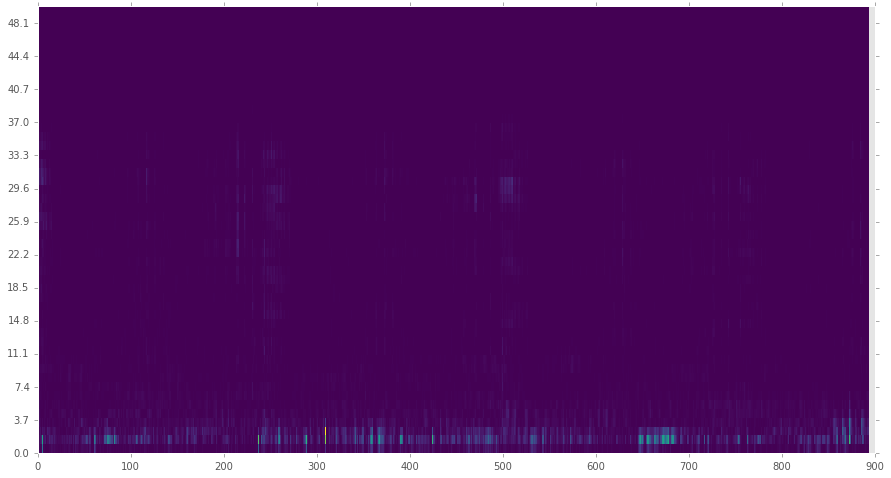

In [6]:
# Ejercicio 1.a.1)
# 8, 44, 80, 131 y 185
# que hacer con los pacientes que tienen distinta cantidad de epochs, interpolacion?
# como mostrar la barra de referencia? y por que hay tan poca variacion
# version para una sola persona

df_concat = pd.DataFrame([])
for x in (8,44,80,131,185):
    df = data1.loc[x]
    df_concat = pd.concat((df_concat, df))
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()

heatmapData = []
for e in range(0, epochs):
    f, Pxx_den = sps.welch(df_means.loc[e], fs=250)
    heatmapData.append(Pxx_den)
heatmapData = np.asarray(heatmapData)
heatmapData = np.transpose(heatmapData)

X = np.arange(0, epochs, 1)
Y = np.arange(0, f.shape[0], 1)
X, Y = np.meshgrid(X, Y)

# colormesh original
plt.figure(figsize=(15, 8))
plt.ylim([0,50])
plt.yticks(np.arange(0, 50, 3.7))
plt.pcolormesh(X, Y, heatmapData, cmap='viridis')
plt.colorbar() #need a colorbar to show the intensity scale
plt.show()

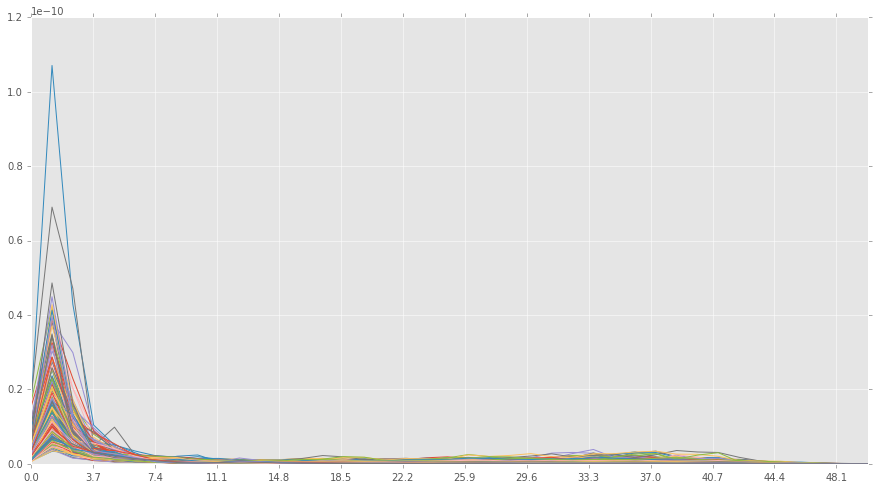

In [7]:
# Ejercicio 1.a.2)
# (grafico realizado para 1 solo sujeto, falta adaptar a los 10 sujetos)
# el grafico queda con muchas puntas, no queda redondito como el del enunciado

plt.figure(figsize=(15, 8))
plt.xlim([0,50])
plt.xticks(np.arange(0, 50, 3.7))

for e in range(0, electrodos):
    densities = []
    for i in range(0, epochs):
        f, Pxx_den = sps.welch(data1.loc[e,i], fs=250)
        densities.append(Pxx_den)
    f = np.asarray(f)
    densities = np.asarray(densities)
    plt.plot(f, densities.mean(axis=0))

plt.show()

In [ ]:
def cortar_frecuencia(frecuencia, potencia):
  i = 0
  while i < len(frecuencia):
    if not frecuencia[i] <= 45 : 
      break
    i = i + 1
  return frecuencia[0:i] , potencia[0:i]

def get_espectro(frecuencia, potencia):
  
  delta = []
  theta = []
  alpha = []
  beta = []
  gamma = []
  i = 0
  while i < len(frecuencia) : 
  
    if frecuencia[i] < 4 : 
      delta.append(potencia[i])
    else : 
      if frecuencia[i] >= 4 and frecuencia[i] < 8 :
        theta.append(potencia[i]) 
      else : 
        if frecuencia[i] >= 9 and frecuencia[i] < 13 :
          alpha.append(potencia[i]) 
        else : 
          if frecuencia[i] >= 13 and frecuencia[i] < 30 :
            beta.append(potencia[i])
          else : 
            gamma.append(potencia[i])
  
    i = i + 1
  
  return delta , theta , alpha , beta , gamma

def ex_b(a):

  promedio = a.mean()
  frecuencia , potencia =  ss.welch(promedio.loc[:], fs = 250)
  frecuencia , potencia = cortar_frecuencia(frecuencia, potencia)
  delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
  #aca nos podemos quedar con el promedio de cada uno o con el maximo ,
  #nos vamos a quedar con el promedio 


In [ ]:
ex_b(a)

In [ ]:
def ex_c(lista_sujetos_minima_conciencia , lista_sujetos_fiambre):
  alphas_minima_conciencia = []
  alphas_sujetos_fiambres = []

  for a in lista_sujetos_minima_conciencia : 
    #calculo el promedio de todos los epochs y los electrodos
    promedio = a.mean()
    frecuencia , potencia =  ss.welch(promedio.loc[:], fs = 250)
    frecuencia , potencia = cortar_frecuencia(frecuencia, potencia)
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    alpha = np.asarray(alpha).mean()
    alphas_minima_conciencia.append(alpha)

  for a in lista_sujetos_fiambre : 
    #calculo el promedio de todos los epochs y los electrodos
    promedio = a.mean()
    frecuencia , potencia =  ss.welch(promedio.loc[:], fs = 250)
    frecuencia , potencia = cortar_frecuencia(frecuencia, potencia)
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    alpha = np.asarray(alpha).mean()
    alphas_sujetos_fiambres.append(alpha)


  #tenemos los datos de los puntos de los minima conciencia y de los q no
  #hay q graficar esos puntos como dos distribuciones distintas y ver como 
  #dan los graficos

  sns.stripplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.swarmplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.boxplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.violinplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.lvplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.pointplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.barplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  sns.countplot(alphas_minima_conciencia, alphas_sujetos_fiambres)
  plt.show()
  

In [ ]:
#hay q armar la lista de los pacientes vivos y muertos y mandarla en este ejercicio
ex_c(lista_vivos, lista_muertos)

In [ ]:
def promedios(lista):
  res = []
  for i in lista : 
    i = np.asarray(i).mean()
    res.append(i)
  return res

def ex_d(lista_sujetos_minima_conciencia , lista_sujetos_fiambre):

  datos_minima_conciencia = []
  datos_sujetos_fiambres = []

  for a in lista_sujetos_minima_conciencia : 
    #calculo el promedio de todos los epochs y los electrodos
    promedio = a.mean()
    frecuencia , potencia =  ss.welch(promedio.loc[:], fs = 250)
    frecuencia , potencia = cortar_frecuencia(frecuencia, potencia)
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    datos = promedios([delta, theta, alpha, beta, gamma])
    datos_minima_conciencia.append(datos)

  for a in lista_sujetos_fiambre : 
    #calculo el promedio de todos los epochs y los electrodos
    promedio = a.mean()
    frecuencia , potencia =  ss.welch(promedio.loc[:], fs = 250)
    frecuencia , potencia = cortar_frecuencia(frecuencia, potencia)
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    datos = promedios([delta, theta, alpha, beta, gamma])
    datos_minima_conciencia.append(datos)


  #tenemos en cada elemento de las listas , una lista con el dato de 
  #delta , theta , alpha , beta , gamma para cada sujeto
  #divido en las distribuciones de los vivos y los muertos 
  #graficar todo eso y realizar un test estadistico

In [ ]:
ex_d(lista_vivos, lista_muertos)

In [ ]:
def normalizar(lista):
  normalizados = []
  for l in lista : 
    mean = l.mean(axis=1)
    std = l.std(axis=1)
    l_normalized = (l.subtract(mean, axis=0).divide(std, axis=0))
    normalizados.append(l_normalized)
  return normalizados

In [ ]:
lista_vivos_normalizados = normalizar(lista_vivos)
lista_muertos_normalizados = normalizar(lista_muertos)